In [1]:
import pandas as pd
import os
import regex as re
import string
import numpy as np
import collections

import contractions
import spacy
#from spacy.tokenizer import Tokenizer
import en_core_web_sm
import nltk
#from nltk.stem import WordNetLemmatizer
from nltk import bigrams
#from sklearn.base import TransformerMixin, BaseEstimator
#import sys

#I know this is silly, but whatever. People love it
from wordcloud import WordCloud



In [2]:
os.chdir("/Users/amywinecoff/Documents/CITP/Research/Github/ai-dialogues/startup-study/data/docs")

In [3]:
##If running for the first time
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

#fix some spacy lemma issues (e.g., "datum" and "scientist" not resulting in "science")
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["scientist"] = ["science"]
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["artificial intelligence"] = ["ai"]


#change/include additional stop words
customize_stop_words = {'not':False, 
                        'yeah':True, 
                        'inaudible':True, 
                        '\n\n':True, 
                        '\n\n\n':True}


for w,val in customize_stop_words.items():
    nlp.vocab[w].is_stop = val
    
    
# lemma_exc = nlp.vocab.lookups.get_table("lemma_exc")
# del lemma_exc[nlp.vocab.strings["noun"]]["data"]

# assert nlp.vocab.morphology.lemmatizer("data", "NOUN") == ["data"]
# assert nlp.vocab.morphology.lemmatizer("scientist", "NOUN") == ["science"]

# #also some custom ones
# assert nlp.vocab.morphology.lemmatizer("venture capitalist", "NOUN") == ["vc"]
# assert nlp.vocab.morphology.lemmatizer("artificial intelligence", "NOUN") == ["ai"]
# assert nlp.vocab.morphology.lemmatizer("machine learning", "NOUN") == ["ml"]

In [ ]:
# #alter default spacy stopwords so 'not' isn't considered a stop word

    

# #Should hopefully deal with contractions
# special_cases = {":)": [{"ORTH": ":)"}]}


    
    
# def custom_tokenizer(nlp, custom_stop_words):
    
#     for w in customize_stop_words:
#         nlp.vocab[w].is_stop = False
        
#     return Tokenizer(nlp.vocab, rules=special_cases)

# nlp.tokenizer = custom_tokenizer(nlp, customize_stop_words)

# nlp = en_core_web_sm.load()

# customize_stop_words = {'not':False, 'yeah':True}

In [4]:
#https://www.kaggle.com/balatmak/text-preprocessing-steps-and-universal-pipeline

class TextPreprocessor(object):
    def __init__(self):
        """
        TBD
        """

    def preprocess_df(self, df):
        return df.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        doc = nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])
    
#     def change_lemma_property(doc):
#         for token in doc:
#             if (token.text in custom_lookup):
#                 token.lemma_ = custom_lookup[token.text]
#         return doc



In [16]:
#replace some words so all texts refer to them the same way throughout
lookup_dict = {
    "artificial intelligence" : "ai", 
    "machine learning" : "ml",
    "venture capitalist": "VC",
    
    }

incorrect_lemma = {
    "datum" : "data", 
    "machine learning" : "ml",
    "venture capitalist": "VC",
    }


# custom_lookup = {'AAA':'Anonyme Affen Allianz','BBB':'Berliner Bauern Bund','CCC':'Chaos Chaoten Club'}


In [17]:
#pid = 'P1'
#industry='Marketing'

all_transcripts_df = pd.DataFrame(columns=['quote', "pid"])
for f in os.listdir():
    if f[0] == "P":
        #print(f)
        transcript = open(f, "r", encoding='utf-8').read().lower()
        transcript = contractions.fix(transcript)
        
        #replace words with acronyms for consistency
        for word, acronym in lookup_dict.items():
            transcript = transcript.replace(word, acronym)
            
        transcript_df = pd.DataFrame(transcript.split('*'), columns=['quote'])
        transcript_df['pid']= int(f[1:-4])
        all_transcripts_df = pd.concat([all_transcripts_df, transcript_df], ignore_index=True)

all_transcripts_df.head()

,quote,pid
0,yeah. let me [inaudible 00:00:11] about the pr...,8
1,my name is [speaker 2]. i take care of content...,8
2,"so here is the thing, [speaker 1]. and that is...",8
3,so we do not actively reach out. we do not do ...,8
4,so whilst youtube was a great space to be and ...,8


In [18]:
all_transcripts_df['pp_text']=(TextPreprocessor().preprocess_df(all_transcripts_df['quote']))


In [9]:
#transcript=transcript_df.groupby(['pid'])['pp_text'].transform(lambda x : ' '.join(x))


# transcript_df['all_text'] = transcript_df[['pp_text','pid']].groupby(['pid'])['pp_text'].transform(lambda x: ','.join(x))
# #transcript_df[['pid','pp_text']].drop_duplicates()

# print(len(transcript_df.loc[0]['all_text']))


all_text = all_transcripts_df[['pid', 'pp_text']].groupby(['pid'], as_index = False).agg({'pp_text': ' '.join})

all_text


,pid,pp_text
0,1,sure companyname software technology company b...
1,2,company develop gen wearable way characterize...
2,3,co founder company call companyname cofounder...
3,4,sure base northeastcity make clinical decision...
4,5,early stage startup company basically focus ma...
5,6,companyname like cambridge analytica privacy i...
6,7,okay companyname basically precision health co...
7,8,let 00:00:11 product ... companyname year old ...
8,9,okay sure head dance easy talk companyname pri...
9,10,current startup early stage pre launch mvp pr...


In [10]:
agg_text = all_text[['pp_text']].apply(','.join).reset_index().iloc[0, 1]
print(agg_text)

sure companyname software technology company base southwest year launch publicly automate marketing planning work startup smb agency enterprise marketing team usually marketer use solution automate market research identify ideal customer profile help customer decision journey tool ai base use course use tool ai base ... help save time identify growth opportunity startup smb enterprise marketing team agency use solution help scale fast let right consider current resource marketing plan resource tool multiply 20 right small promotion customer feedback feature update platform publish share information startup interview prior clubhouse check social schedule check analytic weekly analytic check team plan week talk customer demo check upcoming event preparation kind thing let think main thing month cohost startup interview usually startup story early stage startup like indie hacker maker small team early stage not fund growth traction talk grow startup bootstrappe talk background channel use

In [11]:
# Create counter
word_counts = collections.Counter(agg_text.split())
word_counts.most_common(50)

[('not', 1017),
 ('like', 659),
 ('...', 579),
 ('think', 448),
 ('people', 370),
 ('thing', 366),
 ('data', 320),
 ('lot', 281),
 ('go', 277),
 ('know', 267),
 ('want', 258),
 ('ai', 256),
 ('actually', 237),
 ('work', 231),
 ('company', 212),
 ('try', 206),
 ('right', 190),
 ('time', 176),
 ('way', 174),
 ('use', 169),
 ('kind', 163),
 ('come', 158),
 ('talk', 153),
 ('get', 153),
 ('product', 152),
 ('different', 150),
 ('look', 143),
 ('need', 141),
 ('good', 127),
 ('mean', 124),
 ('help', 122),
 ('ml', 116),
 ('year', 115),
 ('little', 114),
 ('build', 110),
 ('start', 109),
 ('able', 105),
 ('base', 104),
 ('design', 101),
 ('sure', 99),
 ('tell', 99),
 ('term', 92),
 ('model', 91),
 ('say', 90),
 ('okay', 87),
 ('stuff', 87),
 ('question', 86),
 ('algorithm', 86),
 ('understand', 84),
 ('investor', 83)]

In [12]:
# bigrams=list(bigrams(agg_text.split()))
bg = bigrams(agg_text.split())

In [13]:
#https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/
bigram_counts = collections.Counter(bg)

In [14]:
bigram_counts.most_common(50)

[(('not', 'know'), 83),
 (('little', 'bit'), 62),
 (('...', 'not'), 48),
 (('not', 'think'), 43),
 (('not', 'want'), 42),
 (('thing', 'like'), 37),
 (('data', 'scientist'), 37),
 (('feel', 'like'), 31),
 (('like', 'not'), 27),
 (('data', 'science'), 27),
 (('like', 'okay'), 25),
 (('...', 'think'), 25),
 (('...', 'like'), 25),
 (('lot', 'people'), 25),
 (('not', 'go'), 24),
 (('like', 'oh'), 22),
 (('thing', 'not'), 21),
 (('people', 'not'), 21),
 (('...', 'mean'), 21),
 (('deep', 'learning'), 21),
 (('artificial', 'intelligence'), 20),
 (('think', 'like'), 19),
 (('stuff', 'like'), 19),
 (('not', 'like'), 18),
 (('graphic', 'design'), 18),
 (('software', 'developer'), 18),
 (('like', 'hey'), 17),
 (('lot', 'time'), 17),
 (('company', 'not'), 17),
 (('like', '...'), 17),
 (('look', 'like'), 17),
 (('not', 'need'), 17),
 (('lot', 'different'), 16),
 (('genetic', 'data'), 16),
 (('kind', 'thing'), 15),
 (('ask', 'question'), 15),
 (('think', 'lot'), 15),
 (('not', 'work'), 14),
 (('not',

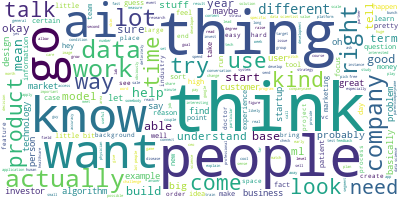

In [15]:
#Create a WordCloud object

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(agg_text)# Visualize the word cloud
wordcloud.to_image()